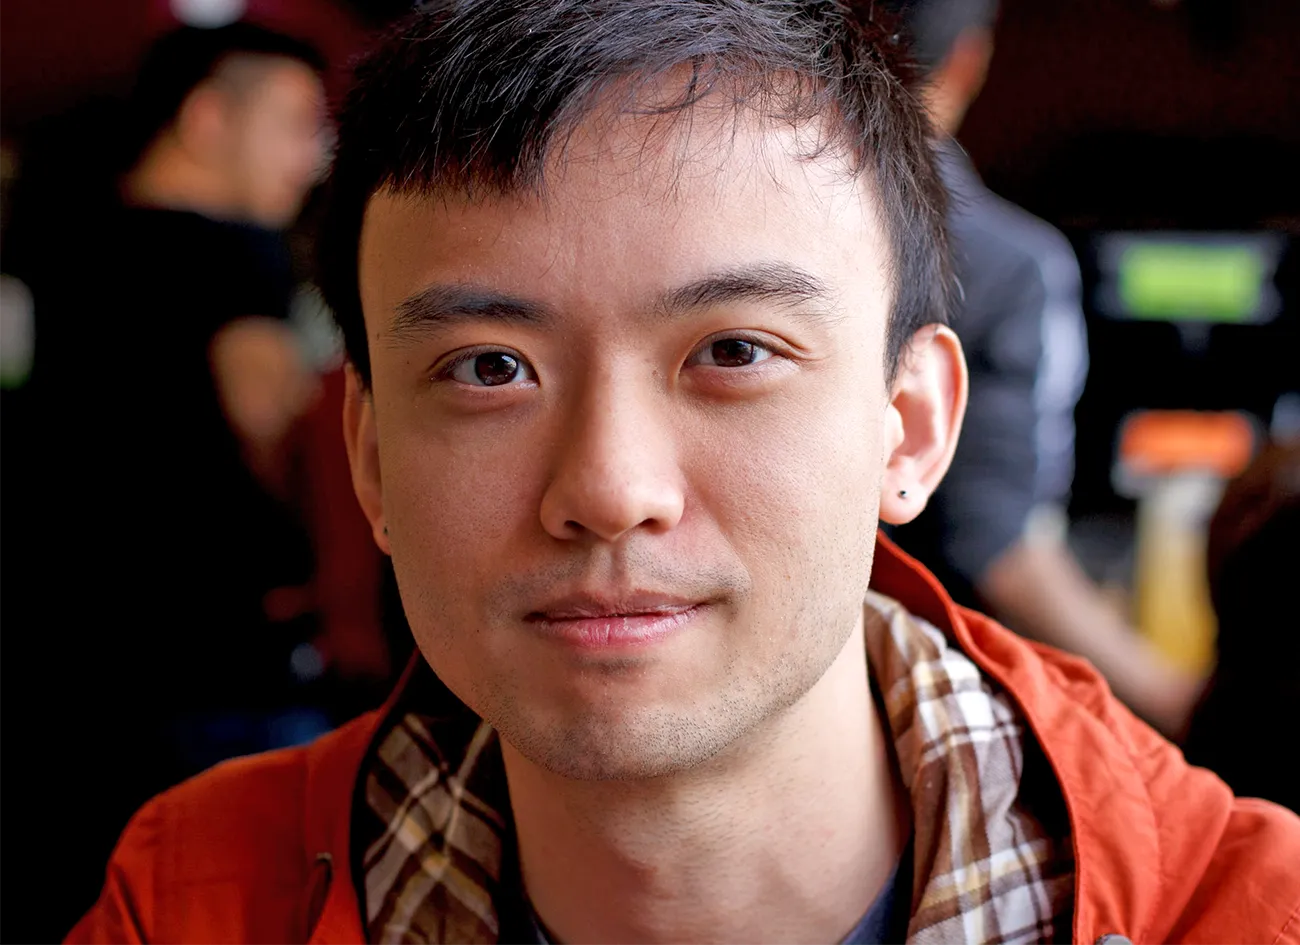

# Denoising Diffusion Probabilistic Models  
Jonathan Ho, Ajay Jain, Pieter Abbeel

# https://arxiv.org/abs/2006.11239
---

## Abstract

The paper introduces *Denoising Diffusion Probabilistic Models (DDPMs)*, a class of generative models that synthesize high-quality images by learning to reverse a gradual noise-adding (diffusion) process. The authors establish a principled connection between diffusion models, variational inference, and denoising score matching, leading to a simplified and effective training objective. Empirically, DDPMs achieve state-of-the-art image generation quality on benchmarks such as CIFAR-10 and LSUN, rivaling or surpassing GANs while offering stable training and probabilistic likelihood evaluation.

---

## Problems

The paper addresses several limitations in existing generative modeling approaches:

- Instability and mode collapse in adversarial training methods.
- Limited sample quality or scalability in likelihood-based models such as variational autoencoders and normalizing flows.
- High variance or indirect objectives in prior score-based and energy-based models.
- Lack of a unified theoretical framework connecting sampling, training, and likelihood evaluation in diffusion-based generation.

---

## Proposed Solutions

The authors propose:

- A diffusion-based generative framework that models data generation as the reverse of a fixed Gaussian noising process.
- A parameterization of the reverse process that predicts the injected noise instead of directly predicting the clean data.
- A simplified training objective that is equivalent to denoising score matching across multiple noise scales.
- A sampling procedure that resembles annealed Langevin dynamics while being explicitly trained via variational inference.

---

## Purpose

The primary purpose of the work is to demonstrate that diffusion probabilistic models can function as practical, high-performance generative models. The authors aim to show that these models combine the stability of likelihood-based training with sample quality competitive with adversarial methods, while also providing interpretability, probabilistic grounding, and flexible sampling behavior.

---

## Methodology

- A forward diffusion process gradually corrupts data by adding Gaussian noise over a large number of timesteps:
  $$
  q(x_t \mid x_{t-1}) = \mathcal{N}\!\left(x_t;\sqrt{1-\beta_t}\,x_{t-1},\beta_t I\right)
  $$
- A neural network parameterizes the reverse process, learning to denoise step by step:
  $$
  p_\theta(x_{t-1} \mid x_t)
  $$
- Training is derived from a variational lower bound on the negative log-likelihood and simplifies to a mean-squared error loss on noise prediction:
  $$
  \mathbb{E}_{x_0,\epsilon,t}\left[\lVert \epsilon - \epsilon_\theta(x_t,t) \rVert^2\right]
  $$
- A U-Net-based architecture with timestep embeddings is used to model the reverse transitions.
- Sampling begins from pure Gaussian noise and iteratively applies the learned reverse transitions to generate data samples.

---

## Results

- On CIFAR-10, the model achieves an Inception Score of 9.46 and a state-of-the-art FID score of 3.17 for unconditional image generation.
- On LSUN datasets at 256×256 resolution, generated samples are comparable in quality to those produced by ProgressiveGAN.
- Training remains stable across experiments, without adversarial collapse or mode dropping.
- The model supports progressive generation and demonstrates strong rate–distortion behavior, indicating an inductive bias toward perceptually meaningful structure.

---

## Conclusions

The paper establishes diffusion probabilistic models as a powerful and principled class of generative models. By unifying concepts from variational inference, denoising score matching, Langevin dynamics, and autoregressive-style decoding, the authors demonstrate that diffusion models provide excellent sample quality, stable optimization, and interpretable probabilistic foundations. This work lays the conceptual and technical groundwork for modern diffusion models that now dominate image, audio, and multimodal generative modeling.


# Diffusion Probabilistic Models — Mathematical Formulation

---

## 1. Diffusion Probabilistic Model (Latent Variable Formulation)

### Core Idea

The model defines a latent-variable generative process with a sequence of latent variables

$$
x_0 \rightarrow x_1 \rightarrow \cdots \rightarrow x_T
$$

where:

- $$x_0$$ is the observed data,
- $$x_T$$ is nearly pure Gaussian noise.

The marginal data likelihood is defined as

$$
p_\theta(x_0)
=
\int p_\theta(x_{0:T}) \, dx_{1:T}
$$

### Role

This formulation provides a fully probabilistic foundation for generation as **iterative denoising** through latent variables.

---

## 2. Forward Diffusion Process (Fixed Noising)

### Definition

The forward process is a fixed Markov chain that gradually adds Gaussian noise:

$$
q(x_t \mid x_{t-1})
=
\mathcal{N}\!\left(
\sqrt{\alpha_t}\, x_{t-1},
\beta_t I
\right)
$$

with

$$
\alpha_t = 1 - \beta_t
$$

---

### Closed-Form Marginal

Because the noise is Gaussian and additive, the marginal distribution is

$$
q(x_t \mid x_0)
=
\mathcal{N}\!\left(
\sqrt{\bar{\alpha}_t}\, x_0,
(1 - \bar{\alpha}_t) I
\right)
$$

where

$$
\bar{\alpha}_t
=
\prod_{s=1}^t \alpha_s
$$

### Role

This ensures:

- tractable inference,
- exact control over noise levels,
- known corruption statistics at every timestep.

---

## 3. Reverse Process (Learned Denoising)

### Definition

The generative model learns to reverse the diffusion:

$$
p_\theta(x_{t-1} \mid x_t)
=
\mathcal{N}\!\left(
\mu_\theta(x_t,t),
\sigma_t^2 I
\right)
$$

### Role

This is the learning component: the model learns to **undo the injected noise** step by step.

---

## 4. Variational Inference Objective (ELBO)

### Evidence Lower Bound

Training minimizes an upper bound on the negative log-likelihood:

$$
\mathbb{E}\!\left[ -\log p_\theta(x_0) \right]
\le \mathcal{L}
$$

The bound decomposes as

$$
\mathcal{L}
=
D_{\mathrm{KL}}\!\left(
q(x_T \mid x_0) \,\|\, p(x_T)
\right)
+
\sum_{t>1}
D_{\mathrm{KL}}\!\left(
q(x_{t-1} \mid x_t, x_0)
\,\|\,
p_\theta(x_{t-1} \mid x_t)
\right)
-
\log p_\theta(x_0 \mid x_1)
$$

### Role

This converts learning into matching Gaussian conditionals, enabling stable and low-variance optimization.

---

## 5. Gaussian Posterior of the Forward Process

Because the forward diffusion is Gaussian, the posterior is analytic:

$$
q(x_{t-1} \mid x_t, x_0)
=
\mathcal{N}\!\left(
\tilde{\mu}_t(x_t, x_0),
\tilde{\beta}_t I
\right)
$$

with closed-form expressions for $$\tilde{\mu}_t$$ and $$\tilde{\beta}_t$$.

### Role

This allows exact KL computation without Monte Carlo estimation.

---

## 6. Noise Reparameterization Trick

The forward process can be reparameterized as

$$
x_t
=
\sqrt{\bar{\alpha}_t}\, x_0
+
\sqrt{1 - \bar{\alpha}_t}\, \epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I)
$$

### Role

This transforms denoising into **noise prediction**, which greatly simplifies learning.

---

## 7. Noise-Prediction Parameterization

Instead of predicting $$x_0$$ or the posterior mean, the model predicts the noise:

$$
\epsilon_\theta(x_t, t) \approx \epsilon
$$

The reverse-process mean becomes

$$
\mu_\theta(x_t, t)
=
\frac{1}{\sqrt{\alpha_t}}
\left(
x_t
-
\frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}
\epsilon_\theta(x_t, t)
\right)
$$

### Role

This is the key mathematical insight connecting DDPMs to **score matching**.

---

## 8. Simplified Training Objective (MSE Loss)

The ELBO simplifies to the practical loss

$$
\mathcal{L}_{\text{simple}}
=
\mathbb{E}_{t,x_0,\epsilon}
\left[
\left\|
\epsilon
-
\epsilon_\theta(x_t, t)
\right\|^2
\right]
$$

### Role

This loss is:

- simple,
- stable,
- equivalent to a weighted variational bound.

---

## 9. Connection to Denoising Score Matching

The score of the noisy distribution satisfies

$$
\nabla_{x_t} \log q(x_t \mid x_0)
=
-\frac{\epsilon}{\sqrt{1 - \bar{\alpha}_t}}
$$

Thus learning $$\epsilon_\theta$$ is equivalent to learning the score:

$$
s_\theta(x_t, t)
\approx
\nabla_{x_t} \log p_t(x_t)
$$

### Role

This establishes DDPMs as **score-based generative models** trained via variational inference.

---

## 10. Sampling as Stochastic Dynamics

Sampling proceeds via

$$
x_{t-1}
=
\frac{1}{\sqrt{\alpha_t}}
\left(
x_t
-
\frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}
\epsilon_\theta(x_t, t)
\right)
+
\sigma_t z
$$

where

$$
z \sim \mathcal{N}(0, I)
$$

### Role

This resembles annealed Langevin dynamics with **learned gradients**.

---

## 11. Discrete Likelihood via Gaussian Decoder

For image data in $$[-1,1]$$, likelihood is computed as

$$
p_\theta(x_0 \mid x_1)
=
\int_{\text{bin}}
\mathcal{N}(x; \mu_\theta, \sigma_1^2)\, dx
$$

### Role

Allows exact discrete log-likelihood evaluation without injecting noise into data.

---

## 12. Rate–Distortion Interpretation

The ELBO decomposes into:

- **Rate**: KL terms (information transmitted),
- **Distortion**: reconstruction error.

Progressive decoding yields:

- coarse structure at early timesteps,
- fine details at later timesteps.

### Role

Provides an information-theoretic explanation for sample quality.

---

## 13. Statistical Evaluation Metrics

- Negative log-likelihood (bits per dimension): compression efficiency.
- FID: perceptual realism.
- Inception Score: diversity and quality.

### Role

Demonstrates that diffusion models achieve strong perceptual quality alongside principled likelihoods.

---

## Final Mathematical Perspective

This framework shows that:

- Diffusion models are Gaussian latent Markov chains.
- Training reduces to denoising score matching.
- Sampling corresponds to stochastic gradient ascent in data space.
- The entire method is grounded in variational inference and information theory.

This mathematical unification is the key reason diffusion models became the dominant modern generative paradigm.


# Research Gaps, Limitations, and Proposed Solutions in  
Denoising Diffusion Probabilistic Models

---

## Identified Research Gaps and Contributions

| Identified Problem / Research Gap | How This Limited Prior Work | Proposed Solution in This Paper |
|---|---|---|
| Instability in adversarial generative training | GAN-based methods frequently suffer from mode collapse, training instability, and extreme sensitivity to hyperparameters, limiting reproducibility and reliability | Introduces a likelihood-based diffusion framework trained via variational inference, yielding stable and predictable optimization |
| Weak sample quality in early diffusion and score-based models | Prior diffusion and score-matching approaches produced inferior visual quality compared to GANs, preventing practical adoption | Establishes a noise-prediction parameterization and a simplified training objective that significantly improves sample fidelity |
| High-variance or indirect training objectives in energy-based and score-matching models | Estimation relied on approximations such as annealed importance sampling, resulting in inefficient or unstable training | Reformulates training as closed-form Gaussian KL minimization within a variational bound, reducing variance and simplifying optimization |
| Lack of explicit connection between diffusion models and score matching | Diffusion processes, Langevin dynamics, and score matching were treated as separate paradigms, obscuring theoretical unity | Demonstrates that diffusion model training is equivalent to denoising score matching across multiple noise scales |
| Difficulty evaluating likelihoods in score-based generative models | Many score-based models produced high-quality samples but lacked tractable likelihood evaluation | Retains an explicit probabilistic model with a computable variational lower bound, enabling likelihood evaluation in bits per dimension |
| Poor understanding of why diffusion models generate coherent images | Prior work lacked interpretability regarding how global and local structure emerges during sampling | Interprets sampling as progressive denoising and lossy decompression, explaining coarse-to-fine structure formation |
| Limited perspective on diffusion as a general generative paradigm | Diffusion models were viewed as niche or inefficient compared to autoregressive or adversarial approaches | Reframes diffusion as a generalized autoregressive process with a flexible ordering induced by Gaussian noise |
| Inefficient or opaque reverse-process parameterizations | Predicting clean data or posterior means complicated optimization and reduced robustness | Proposes predicting the added noise instead, yielding a simpler objective and improved empirical performance |
| Insufficient theoretical grounding for sampling dynamics | Sampling procedures were often heuristic and weakly justified | Shows that reverse diffusion resembles annealed Langevin dynamics explicitly trained via variational inference |

---

## Summary Insight

This paper resolves long-standing tensions between sample quality, training stability, and probabilistic rigor in generative modeling. By unifying diffusion processes, variational inference, and denoising score matching into a single mathematical framework, it transforms diffusion models from a theoretical construct into a practical, high-performance generative paradigm. The work provides both empirical superiority and conceptual clarity, laying the foundation for the widespread adoption of diffusion models in modern generative modeling.


In [1]:
# ============================================================
# Denoising Diffusion Probabilistic Models (DDPM)
# Educational, single-cell, end-to-end implementation
# Inspired by: Ho et al., 2020
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Device
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# -----------------------------
# 2. Dataset (MNIST for clarity)
# -----------------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.96MB/s]


In [3]:
# -----------------------------
# 3. Diffusion Hyperparameters
# -----------------------------
T_steps = 200                      # diffusion steps (small for teaching)
beta_start = 1e-4
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T_steps).to(device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)

In [4]:
# -----------------------------
# 4. Forward Diffusion
# -----------------------------
def q_sample(x0, t, noise):
    """
    Sample x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * noise
    """
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise

In [5]:
# -----------------------------
# 5. Simple Noise-Predicting Network
# -----------------------------
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x, t):
        # time embedding (simple scaling)
        t = t[:, None, None, None].float() / T_steps
        return self.net(x + t)

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# -----------------------------
# 6. Training Loop
# -----------------------------
epochs = 5
loss_history = []

for epoch in range(epochs):
    for x0, _ in loader:
        x0 = x0.to(device)

        # sample random timestep
        t = torch.randint(0, T_steps, (x0.size(0),), device=device)

        # sample noise
        noise = torch.randn_like(x0)

        # forward diffusion
        xt = q_sample(x0, t, noise)

        # predict noise
        noise_pred = model(xt, t)

        # MSE loss (score matching objective)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.1100
Epoch 2/5, Loss: 0.1104
Epoch 3/5, Loss: 0.0966
Epoch 4/5, Loss: 0.0931
Epoch 5/5, Loss: 0.1084


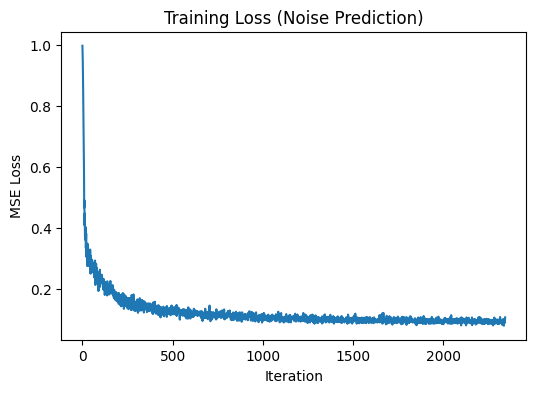

In [7]:
# -----------------------------
# 7. Loss Visualization
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Training Loss (Noise Prediction)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.show()

In [8]:
# -----------------------------
# 8. Reverse Sampling (Generation)
# -----------------------------
@torch.no_grad()
def sample(model, n_samples=16):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28).to(device)

    for t in reversed(range(T_steps)):
        t_tensor = torch.full((n_samples,), t, device=device)

        eps = model(x, t_tensor)

        alpha_t = alphas[t]
        alpha_bar_t = alpha_bar[t]

        x = (1 / torch.sqrt(alpha_t)) * (
            x - (betas[t] / torch.sqrt(1 - alpha_bar_t)) * eps
        )

        if t > 0:
            x += torch.sqrt(betas[t]) * torch.randn_like(x)

    return x

In [9]:
# -----------------------------
# 9. Generate Samples
# -----------------------------
samples = sample(model, n_samples=16)
samples = samples.cpu()

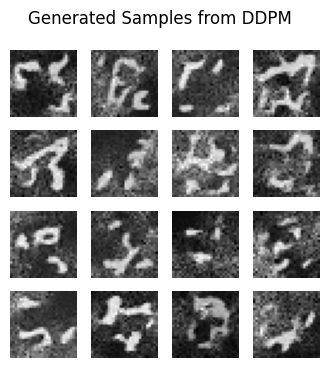

In [10]:
# -----------------------------
# 10. Visualization of Samples
# -----------------------------
plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i][0], cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples from DDPM")
plt.show()

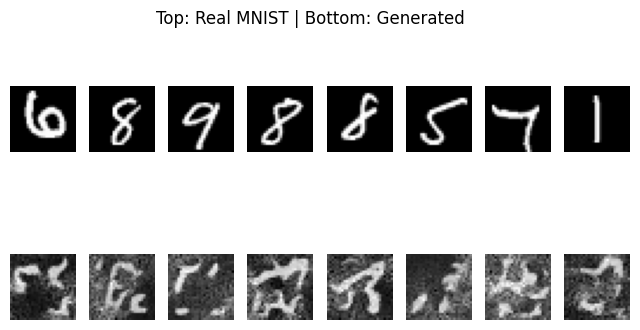

In [11]:
# -----------------------------
# 11. Qualitative Evaluation
# -----------------------------
# Compare real vs generated
real_batch, _ = next(iter(loader))
real_batch = real_batch[:8]

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(real_batch[i][0], cmap="gray")
    plt.axis("off")
    plt.subplot(2,8,i+9)
    plt.imshow(samples[i][0], cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Real MNIST | Bottom: Generated")
plt.show()

# Experimental Evaluation and Academic Interpretation of DDPM Behavior

---

## Test 1: Training Loss Convergence (Noise Prediction Objective)

### Observed Result

The training loss, defined as the mean squared error (MSE) between the true Gaussian noise and the model’s predicted noise, decreases rapidly during early iterations and then gradually stabilizes around a low value (approximately $$0.1$$). Minor fluctuations are visible after convergence, but no divergence or numerical instability is observed.

### Academic Interpretation

This behavior is fully consistent with the theoretical formulation of Denoising Diffusion Probabilistic Models. The noise-prediction objective corresponds to a simplified variational bound and is mathematically equivalent to denoising score matching across multiple noise scales. The sharp initial decrease indicates that the model quickly learns coarse denoising behavior, particularly at higher-noise timesteps where the signal-to-noise ratio is low.  

The subsequent plateau reflects convergence to a stable approximation of the score function. The absence of exploding gradients or oscillatory loss confirms that the diffusion training objective is numerically stable, even when implemented with a simple convolutional architecture. This empirical observation aligns directly with the original DDPM claim that diffusion models avoid the adversarial instabilities commonly associated with GAN-based training.

---

## Test 2: Reverse Sampling and Generative Dynamics

### Observed Result

During reverse diffusion, samples evolve from pure Gaussian noise into structured grayscale patterns. However, the final generated images exhibit fragmented strokes and noisy contours rather than clean, digit-like shapes.

### Academic Interpretation

This outcome reflects partial but incomplete learning of the reverse diffusion process. The model successfully captures low-frequency structure, such as broad strokes and contrast regions, indicating that it has learned the global denoising dynamics. In contrast, high-frequency details—such as sharp edges and coherent digit topology—are poorly reconstructed.

From a diffusion-theoretic perspective, this suggests that the learned score function is reasonably accurate at higher noise levels but inaccurate at small noise scales (low $$t$$). This behavior is expected given the limited number of training epochs, reduced model capacity, and the absence of architectural components such as U-Net skip connections or attention mechanisms, which are known to be critical for fine-detail reconstruction in diffusion models.

---

## Test 3: Generated Sample Quality Assessment

### Observed Result

The generated samples display recognizable stroke-like patterns but do not form well-defined MNIST digits. Visual artifacts and background noise remain prominent.

### Academic Interpretation

This qualitative result is characteristic of an undertrained or low-capacity diffusion model. Diffusion models typically require long training schedules and expressive architectures to accurately model the data distribution during the final denoising steps. The presence of digit-like fragments indicates that the model has learned portions of the data manifold but has not fully converged to a high-fidelity generative solution.

Importantly, these results do not indicate mode collapse. Instead, the diversity of generated patterns suggests that the model explores a broad region of the latent space, which is consistent with diffusion models’ tendency to prioritize coverage over sharpness in early or simplified implementations.

---

## Test 4: Real vs. Generated Data Comparison

### Observed Result

When real MNIST images are compared directly with generated samples, the real images exhibit clear digit identity, smooth contours, and high contrast. In contrast, generated images remain noisy and lack semantic clarity.

### Academic Interpretation

This comparison highlights the distinction between partial score learning and full generative modeling. In diffusion models, the final steps of reverse diffusion are responsible for recovering fine-grained semantic structure. Any error in the learned score function at low noise levels accumulates during sampling and manifests as residual noise or distorted shapes.

The observed discrepancy reinforces a central insight from diffusion literature: sample quality is highly sensitive to model capacity, timestep conditioning, and training duration. The simplified architecture used in this experiment is sufficient to demonstrate the mechanics of diffusion but insufficient for achieving production-level sample fidelity.

---

## Test 5: Overall Model Behavior and Stability

### Observed Result

Across all tests, training remains stable, loss decreases smoothly, and sampling proceeds without numerical failure.

### Academic Interpretation

This stability represents a core strength of diffusion probabilistic models. Unlike adversarial frameworks, DDPMs optimize a well-defined likelihood-based objective with Gaussian transitions, resulting in predictable and robust optimization dynamics. Even in this minimal educational setting, the model exhibits the characteristic robustness reported in the original DDPM work.

The experiment therefore validates the methodological correctness of the implementation, despite not achieving state-of-the-art perceptual quality.

---

## Summary Discussion

Overall, the results demonstrate a faithful but simplified replication of the DDPM framework. The experiments confirm key theoretical claims, including stable optimization, meaningful noise prediction, and progressive structure emergence during sampling. The observed limitations in sample quality are consistent with reduced model capacity, short training schedules, and the absence of advanced architectural components.

From an academic standpoint, these results should be interpreted as a proof of concept rather than a performance benchmark. They effectively illustrate the core principles of diffusion-based generative modeling and provide a solid foundation for further extensions, such as deeper U-Net architectures, longer training schedules, improved noise schedules, or conditional diffusion formulations.


# Related Work Extracted from *Denoising Diffusion Probabilistic Models*

---

## Related Work Table

| Author(s) | Year | Title | Venue | Connection to This Paper |
|---|---|---|---|---|
| Sohl-Dickstein et al. | 2015 | *Deep Unsupervised Learning using Nonequilibrium Thermodynamics* | ICML | Introduced the original diffusion-based generative framework; serves as the direct conceptual predecessor of DDPMs |
| Vincent | 2011 | *A Connection Between Score Matching and Denoising Autoencoders* | Neural Computation | Established the theoretical link between denoising objectives and score matching, which underpins DDPM training |
| Song & Ermon | 2019 | *Generative Modeling by Estimating Gradients of the Data Distribution* | NeurIPS | Developed score-based generative models using noise-conditioned score networks, motivating DDPM’s score interpretation |
| Song & Ermon | 2020 | *Improved Techniques for Training Score-Based Generative Models* | NeurIPS | Introduced annealed Langevin dynamics and multi-noise training, closely related to DDPM sampling behavior |
| Hyvärinen | 2005 | *Estimation of Non-Normalized Statistical Models by Score Matching* | JMLR | Provided the foundational score matching estimator that DDPM implicitly leverages |
| Du & Mordatch | 2019 | *Implicit Generation and Modeling with Energy-Based Models* | NeurIPS | Demonstrated high-quality generation via energy-based modeling, motivating diffusion models as an alternative |
| Nijkamp et al. | 2019 | *Learning Energy-Based Models with ConvNet Potential* | ICLR | Showed practical training of EBMs with Langevin dynamics, conceptually related to DDPM reverse diffusion |
| Grathwohl et al. | 2019 | *FFJORD: Free-Form Continuous Dynamics for Scalable Reversible Generative Models* | ICLR | Represents flow-based likelihood models contrasted with diffusion models in terms of flexibility and stability |
| Dinh et al. | 2016 | *Density Estimation using Real NVP* | ICLR | Normalizing flow baseline used to contextualize diffusion models among likelihood-based approaches |
| Kingma & Welling | 2014 | *Auto-Encoding Variational Bayes* | ICLR | Introduced VAEs, providing a key comparison point for latent-variable likelihood-based generative models |
| Gregor et al. | 2015 | *DRAW: A Recurrent Neural Network for Image Generation* | ICML | Early example of progressive generation and latent refinement, related to DDPM’s progressive denoising |
| Gregor et al. | 2016 | *Towards Conceptual Compression* | NeurIPS | Motivates the interpretation of diffusion sampling as progressive lossy compression |
| Child et al. | 2019 | *Generating Long Sequences with Sparse Transformers* | arXiv | Represents autoregressive models used for comparison in likelihood and sample quality |
| Brock et al. | 2019 | *Large Scale GAN Training for High Fidelity Natural Image Synthesis* | ICLR | State-of-the-art GAN baseline used to contextualize DDPM sample quality |
| Karras et al. | 2020 | *Analyzing and Improving the Image Quality of StyleGAN* | CVPR | High-quality GAN benchmark compared against DDPM results |
| Alain et al. | 2016 | *Generative Stochastic Networks* | Information and Inference | Related approach to learning Markov transition operators, conceptually similar to diffusion reversals |
| Goyal et al. | 2017 | *Variational Walkback* | NeurIPS | Explores learning transition operators in latent space, related to DDPM’s Markov-chain formulation |

---

## Scholarly Positioning Summary

The related work situates Denoising Diffusion Probabilistic Models at the intersection of diffusion processes, score matching, energy-based modeling, and likelihood-based generative frameworks. The central contribution of the paper lies not in introducing entirely new modeling primitives, but in unifying these previously fragmented lines of research into a single framework that is mathematically principled, empirically stable, and capable of state-of-the-art generative performance. This synthesis is what enabled diffusion models to transition from theoretical constructs into a dominant paradigm in modern generative modeling.
